In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from imblearn.over_sampling import SMOTE
print('numpy version : ',np.__version__)
print('pandas version : ',pd.__version__)
print('seaborn version : ',sns.__version__)

from mpl_toolkits.mplot3d import Axes3D

from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

numpy version :  2.0.2
pandas version :  2.2.2
seaborn version :  0.13.2


## Tahap 1: Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# path file di google drive
file_path = "/content/drive/MyDrive/Take Home Test - Tiara Delfira/Food_Delivery_Times.csv"

df = pd.read_csv(file_path)

In [ ]:
df.head(), df.info(), df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Order_ID                1000 non-null   int64  
 1   Distance_km             1000 non-null   float64
 2   Weather                 970 non-null    object 
 3   Traffic_Level           970 non-null    object 
 4   Time_of_Day             970 non-null    object 
 5   Vehicle_Type            1000 non-null   object 
 6   Preparation_Time_min    1000 non-null   int64  
 7   Courier_Experience_yrs  970 non-null    float64
 8   Delivery_Time_min       1000 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 70.4+ KB


(   Order_ID  Distance_km Weather Traffic_Level Time_of_Day Vehicle_Type  \
 0       522         7.93   Windy           Low   Afternoon      Scooter   
 1       738        16.42   Clear        Medium     Evening         Bike   
 2       741         9.52   Foggy           Low       Night      Scooter   
 3       661         7.44   Rainy        Medium   Afternoon      Scooter   
 4       412        19.03   Clear           Low     Morning         Bike   
 
    Preparation_Time_min  Courier_Experience_yrs  Delivery_Time_min  
 0                    12                     1.0                 43  
 1                    20                     2.0                 84  
 2                    28                     1.0                 59  
 3                     5                     1.0                 37  
 4                    16                     5.0                 68  ,
 None,
            Order_ID  Distance_km Weather Traffic_Level Time_of_Day  \
 count   1000.000000  1000.000000     970  

## Tahap 2: Data Preprocessing

In [ ]:
import numpy as np

# Salin data untuk preprocessing
df_clean = df.copy()

# Tangani missing values - imputasi dengan modus untuk kategorikal dan median untuk numerik
categorical_cols = ['Weather', 'Traffic_Level', 'Time_of_Day']
numerical_cols = ['Courier_Experience_yrs']

for col in categorical_cols:
    df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)

for col in numerical_cols:
    df_clean[col].fillna(df_clean[col].median(), inplace=True)

# Drop kolom Order_ID karena tidak informatif untuk model
df_clean.drop(columns=['Order_ID'], inplace=True)

# Buat target klasifikasi berdasarkan Delivery_Time_min
def label_delivery_time(minute):
    if minute < 45:
        return 'Cepat'
    elif minute <= 70:
        return 'Standar'
    else:
        return 'Lama'

df_clean['Delivery_Class'] = df_clean['Delivery_Time_min'].apply(label_delivery_time)

# Drop kolom original target numerik
df_clean.drop(columns=['Delivery_Time_min'], inplace=True)

# Encoding fitur kategorikal
df_encoded = pd.get_dummies(df_clean, drop_first=True)

# Cek hasil akhir preprocessing
df_encoded.head()

,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Weather_Foggy,Weather_Rainy,Weather_Snowy,Weather_Windy,Traffic_Level_Low,Traffic_Level_Medium,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,Vehicle_Type_Car,Vehicle_Type_Scooter,Delivery_Class_Lama,Delivery_Class_Standar
0,7.93,12,1.0,False,False,False,True,True,False,False,False,False,False,True,False,False
1,16.42,20,2.0,False,False,False,False,False,True,True,False,False,False,False,True,False
2,9.52,28,1.0,True,False,False,False,True,False,False,False,True,False,True,False,True
3,7.44,5,1.0,False,True,False,False,False,True,False,False,False,False,True,False,False
4,19.03,16,5.0,False,False,False,False,True,False,False,True,False,False,False,False,True


## Tahap 3: Eksplorasi Data (Exploratory Data Analysis - EDA)

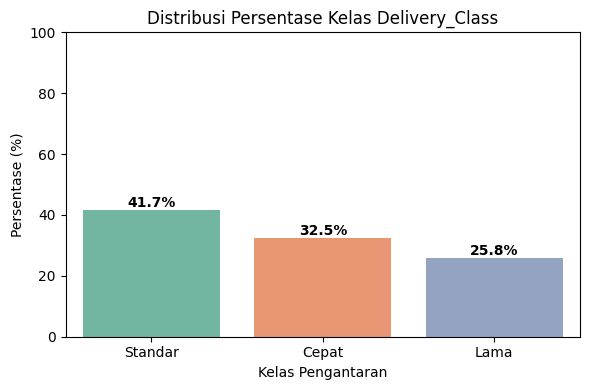

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Hitung distribusi kelas dalam persentase
class_percentages = df_clean['Delivery_Class'].value_counts(normalize=True) * 100

# Plot bar
plt.figure(figsize=(6, 4))
sns.barplot(x=class_percentages.index, y=class_percentages.values, palette='Set2')
plt.title('Distribusi Persentase Kelas Delivery_Class')
plt.xlabel('Kelas Pengantaran')
plt.ylabel('Persentase (%)')
plt.ylim(0, 100)

# Tambahkan label persentase di atas batang
for i, v in enumerate(class_percentages.values):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

1. Distribusi Kelas Delivery_Class
- Cepat: 32.5%
- Standar: 41.7%
- Lama:25.8%

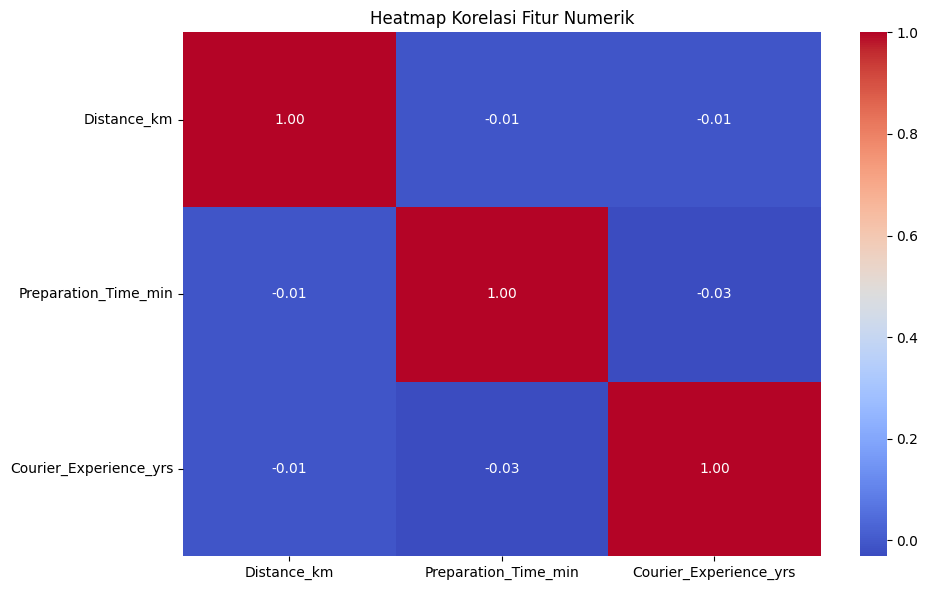

In [ ]:
# Korelasi fitur numerik
plt.figure(figsize=(10, 6))
sns.heatmap(df_clean.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap Korelasi Fitur Numerik')
plt.tight_layout()
plt.show()

Hasil Korelasi:
- Distance_km vs Preparation_Time_min: Korelasi sebesar -0.01, menunjukkan tidak adanya hubungan linear yang signifikan antara jarak tempuh dan waktu persiapan.
- Distance_km vs Courier_Experience_yrs: Korelasi sebesar -0.01, juga menunjukkan tidak ada hubungan linear yang berarti antara pengalaman kurir dan jarak tempuh.
- Preparation_Time_min vs Courier_Experience_yrs: Korelasi sebesar -0.03, artinya pengalaman kurir hampir tidak berpengaruh terhadap waktu persiapan.
- Diagonal (nilai 1.00): Setiap fitur berkorelasi sempurna dengan dirinya sendiri, yang memang sudah semestinya.

Kesimpulan

Fitur Distance_km, Preparation_Time_min, dan Courier_Experience_yrs bersifat independen satu sama lain, sehingga dapat digunakan secara bersamaan dalam analisis atau pemodelan tanpa khawatir akan adanya pengaruh korelasi yang kuat di antara mereka.

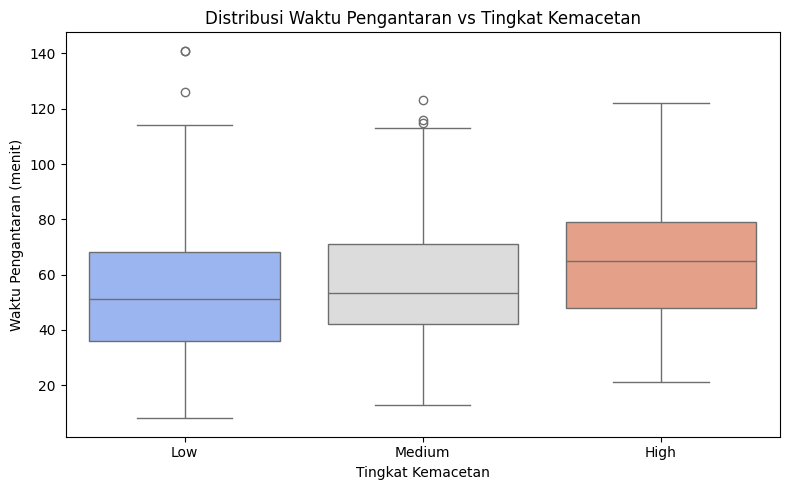

In [ ]:
# Boxplot waktu pengantaran berdasarkan Traffic_Level
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='Traffic_Level', y='Delivery_Time_min', palette='coolwarm')
plt.title('Distribusi Waktu Pengantaran vs Tingkat Kemacetan')
plt.xlabel('Tingkat Kemacetan')
plt.ylabel('Waktu Pengantaran (menit)')
plt.tight_layout()
plt.show()

3. Boxplot vs Traffic_Level
- Waktu pengantaran cenderung lebih lama saat Traffic_Level adalah High.
- Traffic Level "Low" dan "Medium" memiliki distribusi waktu yang lebih singkat dan stabil.

Analisis:
- Tingkat kemacetan merupakan fitur penting yang memengaruhi durasi pengantaran dan skor review.

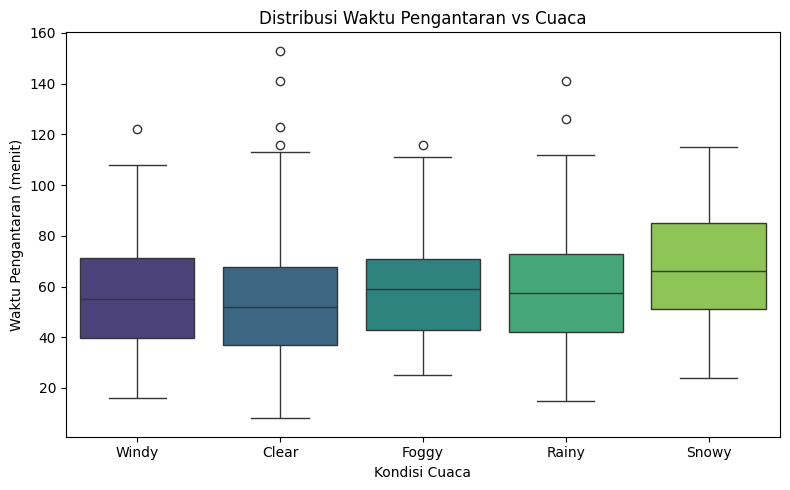

In [ ]:
# Boxplot waktu pengantaran berdasarkan Weather
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='Weather', y='Delivery_Time_min', palette='viridis')
plt.title('Distribusi Waktu Pengantaran vs Cuaca')
plt.xlabel('Kondisi Cuaca')
plt.ylabel('Waktu Pengantaran (menit)')
plt.tight_layout()
plt.show()

4. Boxplot vs Weather
- Snowy dan Rainy memiliki outlier dan waktu pengantaran yang lebih tinggi dibanding kondisi cuaca normal.
- Clear dan Windy cenderung memiliki waktu pengantaran yang lebih cepat.

Analisis:
- Cuaca buruk (hujan/salju) jelas berdampak negatif terhadap waktu pengiriman, dan mungkin berdampak pada skor review pelanggan.

## Tahap 4: Pengembangan Model Machine Learning

Persiapan Dataset dan Splitting

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Fitur (X) dan target (y)
X = df_encoded.drop(columns=['Delivery_Class_Lama', 'Delivery_Class_Standar'])  # drop dummy target
y = df_clean['Delivery_Class']

# Encode label target
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # 'Cepat' = 0, 'Standar' = 1, 'Lama' = 2

# Bagi dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

Pembuatan dan Evaluasi Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Inisialisasi model
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

# Latih dan evaluasi
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))


Logistic Regression Accuracy: 0.7600
Confusion Matrix:
 [[54  0 11]
 [ 3 35 14]
 [ 5 15 63]]
Classification Report:
               precision    recall  f1-score   support

       Cepat       0.87      0.83      0.85        65
        Lama       0.70      0.67      0.69        52
     Standar       0.72      0.76      0.74        83

    accuracy                           0.76       200
   macro avg       0.76      0.75      0.76       200
weighted avg       0.76      0.76      0.76       200


Decision Tree Accuracy: 0.6600
Confusion Matrix:
 [[48  1 16]
 [ 2 32 18]
 [ 9 22 52]]
Classification Report:
               precision    recall  f1-score   support

       Cepat       0.81      0.74      0.77        65
        Lama       0.58      0.62      0.60        52
     Standar       0.60      0.63      0.62        83

    accuracy                           0.66       200
   macro avg       0.67      0.66      0.66       200
weighted avg       0.67      0.66      0.66       200


Random 

Analisis
1. Akurasi
- Logistic Regression memiliki akurasi tertinggi (76%), diikuti oleh Random Forest (72.5%), dan Decision Tree (66%).
- Ini menunjukkan Logistic Regression lebih baik dalam mengklasifikasikan keseluruhan data dengan benar.

2. Precision
- Precision tertinggi untuk kelas "Cepat" dicapai oleh Logistic Regression (0.87), artinya model ini paling sedikit menghasilkan false positive untuk kelas Cepat.
- Decision Tree memiliki precision terendah terutama di kelas "Lama" dan "Sedang", menunjukkan lebih banyak false positive.
- Random Forest berada di tengah-tengah, lebih baik dari Decision Tree tapi sedikit di bawah Logistic Regression.

3. Recall
- Recall tertinggi untuk kelas "Cepat" juga dimiliki Logistic Regression (0.83), artinya model ini mampu menangkap sebagian besar kasus Cepat.
- Recall kelas "Lama" dan "Sedang" juga lebih baik di Logistic Regression dibandingkan model lain.
- Decision Tree memiliki recall terendah, menunjukkan banyak false negative.

4. F1-score
- F1-score yang merupakan harmonisasi precision dan recall, paling tinggi di Logistic Regression untuk semua kelas.
- Random Forest cukup kompetitif, terutama untuk kelas "Cepat" dan "Sedang".
- Decision Tree paling rendah, menandakan performa yang kurang seimbang antara precision dan recall.

5. Confusion Matrix
- Logistic Regression menunjukkan distribusi kesalahan yang lebih sedikit, terutama untuk kelas "Cepat" dan "Sedang".
- Decision Tree banyak salah klasifikasi antara kelas "Lama" dan "Sedang".
- Random Forest memperbaiki kesalahan Decision Tree, namun masih ada kesalahan signifikan antara kelas "Lama" dan "Sedang".

Kesimpulan
- Logistic Regression adalah model terbaik secara keseluruhan untuk dataset ini, dengan akurasi, precision, recall, dan f1-score tertinggi.
- Random Forest merupakan alternatif yang baik dengan performa cukup mendekati Logistic Regression, terutama untuk kelas "Cepat" dan "Sedang".
- Decision Tree memiliki performa paling rendah dan cenderung melakukan kesalahan klasifikasi lebih banyak, terutama pada kelas "Lama" dan "Sedang"

Validasi Silang dan Tuning

In [ ]:
from sklearn.model_selection import cross_val_score

# Validasi silang (5-fold)
for name, model in models.items():
    scores = cross_val_score(model, X, y_encoded, cv=5, scoring='accuracy')
    print(f"{name} Cross-Validation Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

Logistic Regression Cross-Validation Accuracy: 0.7930 ± 0.0311
Decision Tree Cross-Validation Accuracy: 0.6970 ± 0.0201
Random Forest Cross-Validation Accuracy: 0.7480 ± 0.0191


Hyperparameter Tuning untuk Random Forest

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Grid parameter
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Model dasar
rf = RandomForestClassifier(random_state=42)

# Grid Search
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Jalankan grid search
grid_search_rf.fit(X_train, y_train)

# Ambil model terbaik
best_rf = grid_search_rf.best_estimator_
print("Best Parameters:", grid_search_rf.best_params_)
print("Best Cross-Validation Accuracy:", grid_search_rf.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}
Best Cross-Validation Accuracy: 0.7675000000000001


Model Terbaik - Random Forest

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Accuracy: 0.7250

Classification Report:
              precision    recall  f1-score   support

       Cepat       0.81      0.80      0.81        65
        Lama       0.69      0.63      0.66        52
     Standar       0.68      0.72      0.70        83

    accuracy                           0.72       200
   macro avg       0.73      0.72      0.72       200
weighted avg       0.73      0.72      0.72       200



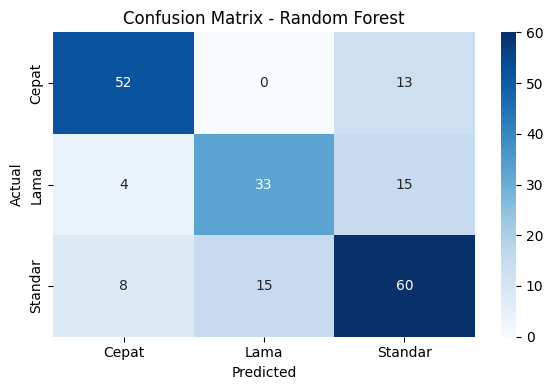

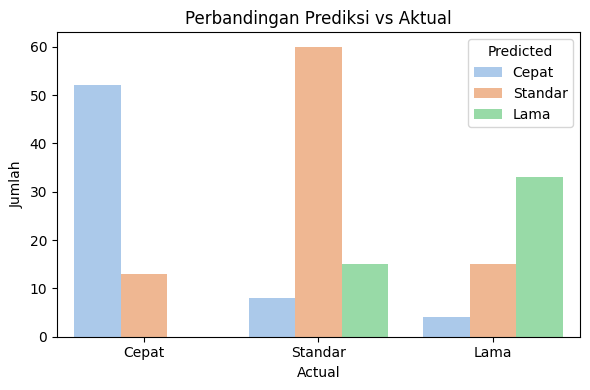

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Parameter untuk RandomizedSearchCV
param_dist_rf = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Model dasar
rf = RandomForestClassifier(random_state=42)

# Randomized Search CV
random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist_rf,
    n_iter=20,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Latih model
random_search_rf.fit(X_train, y_train)

# Ambil model terbaik
best_rf_random = random_search_rf.best_estimator_

# Prediksi
y_pred = best_rf_random.predict(X_test)

# Evaluasi akurasi dan laporan klasifikasi
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Visualisasi Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Perbandingan aktual vs prediksi
result_df = pd.DataFrame({
    'Actual': le.inverse_transform(y_test),
    'Predicted': le.inverse_transform(y_pred)
})

plt.figure(figsize=(6, 4))
sns.countplot(data=result_df, x='Actual', hue='Predicted', palette='pastel')
plt.title("Perbandingan Prediksi vs Aktual")
plt.ylabel("Jumlah")
plt.tight_layout()
plt.show()

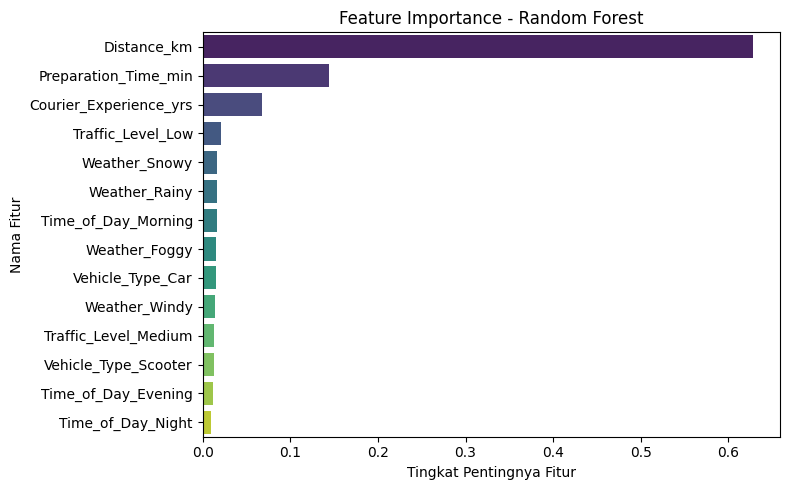

,Feature,Importance
0,Distance_km,0.627507
1,Preparation_Time_min,0.144139
2,Courier_Experience_yrs,0.067163
7,Traffic_Level_Low,0.020809
5,Weather_Snowy,0.016671


In [ ]:
import numpy as np

# Ambil nama fitur dari dataset
feature_names = X_train.columns

# Ambil nilai importance dari model
importances = best_rf_random.feature_importances_

# Buat dataframe untuk visualisasi
feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot bar chart
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis')
plt.title('Feature Importance - Random Forest')
plt.xlabel('Tingkat Pentingnya Fitur')
plt.ylabel('Nama Fitur')
plt.tight_layout()
plt.show()

feat_imp.head(5)

In [ ]:
df.to_csv('delivery_food.csv', index=False)

In [ ]:
from google.colab import files
files.download('delivery_food.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>